In [36]:
import warnings
warnings.filterwarnings('ignore')

import torch
import numpy as np
import os
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
import time

from isochrones import get_ichrone
from sbi import analysis
import corner
import pandas as pd
from sbi.utils import process_prior
from sbi import utils
from sbi.inference import SNPE as method

l_ = ['Melotte_22','NGC_2632','Trumpler_10']
list_clusters = ['Alessi_5','Alessi_9','ASCC_101','BH_99','Blanco_1','IC_2602','NGC_2516','NGC_2547','NGC_3532','NGC_6475','NGC_7058','Pozzo_1'] + l_


from astroquery.vizier import Vizier

catalog = 'J/A+A/689/A18/clusters' # Exploring Galactic open clusters
query = Vizier(catalog=catalog, row_limit=-1).query_constraints()[0]
our_clusters = query.to_pandas()

our_clusters = our_clusters[our_clusters['Cluster'].isin(list_clusters)]
our_clusters = our_clusters[['Cluster','logAge','Z']]

age_lower, age_upper = (10**min(our_clusters['logAge']))/1e9, (10**max(our_clusters['logAge']))/1e9 
fe_h_lower, fe_h_upper = min(our_clusters['Z']), max(our_clusters['Z'])

print('fe_h boundaries= ', fe_h_lower, fe_h_upper)
print('age boundaries= ', age_lower, age_upper)

our_clusters

fe_h boundaries=  -0.068984 0.1977565
age boundaries=  0.011622030210056504 0.946313422144074


,Cluster,logAge,Z
1,ASCC_101,8.441943,0.004296
41,Alessi_5,7.689649,0.063241
45,Alessi_9,8.480562,-0.001264
55,BH_99,7.658123,0.067202
56,Blanco_1,7.900269,-0.015503
99,IC_2602,7.519236,-0.015298
110,Melotte_22,8.014878,0.028664
138,NGC_2516,8.829206,0.004662
141,NGC_2547,7.441043,-0.013032
143,NGC_2632,8.976035,0.197757


In [2]:
# catalog = 'J/A+A/689/A18/members' # Exploring Galactic open clusters
# query = Vizier(catalog=catalog, row_limit=-1).query_constraints()[0]
# members = query.to_pandas()
# members = members[members['Cluster'].isin(list_clusters)]
# members

# Define simulator

In [37]:
tracks = get_ichrone('mist', tracks=True)


def binary_color_mag_isochrones(m1, q, age, fe_h, log_dist):
    # isochrones.py needs log10(Age [yr]). 
    # Our age is in Gyr, so we take log10(age * 10^9) = log10(age) + 9
    dist = np.float64(10**log_dist)
    properties = tracks.generate_binary(m1, q * m1, np.log10(age) + 9, fe_h, distance=dist, bands=["G", "BP", "RP"])
    
    #g_mag = properties.G_mag.values[0]
    bp_mag = properties.BP_mag.values[0]
    rp_mag = properties.RP_mag.values[0]
    dist = np.array(dist)
    g_mag = properties.G_mag.values[0] - 5* np.log10(dist) + 5
    
    return np.array([g_mag, bp_mag, rp_mag, dist]).T

def simulator(theta):
    return torch.tensor(binary_color_mag_isochrones(*theta))

In [ ]:
# class StellarPrior:

#     def __init__(
#         self, 
#         M1_bounds=(0.3, 5.0),   
#         q_bounds=(0.0, 1.0),    
#         tau_bounds=(age_lower, age_upper), 
#         m_h_bounds=(fe_h_lower, fe_h_upper), 
#         distance_bounds=(100.0, 1000.0), 
#         M1_alpha=1.0,
#         M1_beta=5.0,
#         m_h_alpha=10.0,
#         m_h_beta=2.0,
#         m_h_scale=3.0,
#         return_numpy=False
#     ):
#         self.bounds = dict(
#             lower_bound=tt([M1_bounds[0], q_bounds[0], tau_bounds[0], m_h_bounds[0], distance_bounds[0]]),
#             upper_bound=tt([M1_bounds[1], q_bounds[1], tau_bounds[1], m_h_bounds[1], distance_bounds[1]])
#         )
#         self.lower = tt([M1_alpha, 1.0, 1.0, m_h_alpha, 1.0])
#         self.upper = tt([M1_beta, 1.0, 1.0, m_h_beta, 1.0])
#         m_h_mode = (m_h_alpha - 1)/(m_h_alpha + m_h_beta - 2)
#         loc = tt([M1_bounds[0], q_bounds[0], tau_bounds[0], -m_h_mode * m_h_scale, distance_bounds[0]])
#         scale = tt([M1_bounds[1], q_bounds[1], tau_bounds[1], m_h_scale, distance_bounds[1]])
#         self.return_numpy = return_numpy
#         self.dist = Independent(TransformedDistribution(Beta(self.lower, self.upper, validate_args=False), AffineTransform(loc=loc, scale=scale)), 1)

#     def sample(self, sample_shape=torch.Size([])):
#         samples = self.dist.sample(sample_shape)
#         return samples.numpy() if self.return_numpy else samples

#     def log_prob(self, values):
#         if self.return_numpy:
#             values = torch.as_tensor(values)
#         log_probs = self.dist.log_prob(values)
#         return log_probs.numpy() if self.return_numpy else log_probs


#import sbi.utils.user_input_checks 
#print(dir(sbi.utils.user_input_checks ))

# custom_prior = StellarPrior()
# prior, *_ = process_prior(custom_prior, custom_prior_wrapper_kwargs=custom_prior.bounds)

In [38]:
age_lower, age_upper

(0.011622030210056504, 0.946313422144074)

In [ ]:
5*10**6 / 10**9

# Set priors

In [39]:
from torch.distributions import (Uniform, Beta, Pareto, Independent)
from torch.distributions.transforms import AffineTransform
from torch.distributions.transformed_distribution import TransformedDistribution

from torch import tensor as tt

#from sbi.inference import simulate_for_sbi
from sbi.utils.user_input_checks import prepare_for_sbi


age_bounds = [0.01, 10.0]           # Gyr
mass_bounds = [0.2, 10.0]           # M1
metallicity_bounds = [-2.0, 0.5]    # [Fe/H]
distance_bounds = [100.0, 1000.0]   # log10(distance / pc)


num_simulations = 100_000
num_samples = 2_000

select_prior = 1

if select_prior == 1:

    # prior = [
    #     TransformedDistribution(Pareto(scale=tt([1.]), alpha=tt([5.])), AffineTransform(loc=tt([0.3]), scale=tt([5.0]))), # M!
    #     Uniform(tt([0.]), tt([1.])),                                                                                      # q
    #     Uniform(tt([age_lower]), tt([age_upper])),                                                                        # age
    #     TransformedDistribution(Beta(tt([10.]), tt([2.])), AffineTransform(loc=tt([fe_h_lower]), scale=tt([fe_h_upper]))) # [Fe/H]
    # ]

    prior = [
    TransformedDistribution(Pareto(scale=tt([1.]), alpha=tt([5.])), \
                            AffineTransform(loc=tt([mass_bounds[0]]), scale=tt([mass_bounds[1]]))),                   # M!
    Uniform(tt([0.]), tt([1.])),                                                                                      # q
    Uniform(tt([age_bounds[0]]), tt([age_bounds[1]])),                                                                # age
    TransformedDistribution(Beta(tt([10.]), tt([2.])), \
                            AffineTransform(loc=tt([metallicity_bounds[0]]), scale=tt([metallicity_bounds[1]]))),     # [Fe/H]
    Uniform(tt([np.log10(distance_bounds[0])]), tt([np.log10(distance_bounds[1])]))                                   # log10(dist)
    ]

elif select_prior == 2:
    bounds = np.array([
    [mass_bounds[0],  mass_bounds[1]],                           # M1
    [0,      1],                                                 # q
    [age_bounds[0],   age_bounds[1]],                            # (Gyr)
    [metallicity_bounds[0], metallicity_bounds[1]],              # metallicity
    [np.log10(distance_bounds[0]), np.log10(distance_bounds[1])] # log10(distance)
    ])

    bounds = torch.tensor(bounds)
    prior = utils.BoxUniform(low=bounds.T[0], high=bounds.T[1])


sbi_simulator, sbi_prior = prepare_for_sbi(simulator, prior)
inference = method(sbi_prior)

In [ ]:
# 0.011622030210056504 0.946313422144074

# Generate the simulations. 
## Run if a new posterior is required
### We do this ourselves (instead of using simulate_for_sbi) because if we don't then many will be NaNs and we end up with fewer simulations than we want.

In [40]:
def simulate_for_sbi_strict(simulator, proposal, num_simulations, max_trials=np.inf):
    num_trials, num_simulated, theta, x = (0, 0, [], [])
    
    while num_simulated < num_simulations:
        N = num_simulations - num_simulated
        print(f"Running {N} simulations")
        _theta = proposal.sample((N, ))
        _x = simulator(_theta)
        _x = _x.squeeze(1)  # This will change it from [1, 1, 3] to [1, 3]
        #_theta, _x = simulate_for_sbi(simulator, proposal=proposal, num_simulations=N)
        keep = np.all(np.isfinite(_x).numpy(), axis=1)
        
        theta.extend(np.array(_theta[keep]))
        x.extend(np.array(_x[keep]))

        num_trials += 1
        num_simulated += sum(keep)
        if num_trials > max_trials:
            print(f"Warning: exceeding max trials ({max_trials}) with {num_simulated} / {num_simulations} simulations")
            break
    theta = torch.tensor(np.vstack(theta))
    x = torch.tensor(np.vstack(x))
    return (theta, x)

In [4]:
# def simulate_for_sbi_strict(simulator, proposal, num_simulations, max_trials=np.inf):
#     num_trials, num_simulated, theta, x = (0, 0, [], [])

#     with tqdm(total=num_simulations) as pbar:
    
#         while num_simulated < num_simulations:
#             time.sleep(0.1)

#             N = num_simulations - num_simulated
#             print(f"Running {N} simulations")
#             _theta = proposal.sample((N, ))
#             _x = simulator(_theta)
#             _x = _x.squeeze(1)  # This will change it from [1, 1, 3] to [1, 3]
#             keep = np.all(np.isfinite(_x).numpy(), axis=1)
            
#             theta.extend(np.array(_theta[keep]))
#             x.extend(np.array(_x[keep]))

#             num_trials += 1
#             num_simulated += sum(keep)

#             pbar.update(sum(keep))

#             if num_trials > max_trials:
#                 print(f"Warning: exceeding max trials ({max_trials}) with {num_simulated} / {num_simulations} simulations")
#                 break
    
#     theta = torch.tensor(np.vstack(theta))
#     x = torch.tensor(np.vstack(x))
#     return (theta, x)

# Build or load posterior

In [41]:
#posterior_path = "./data/train_posterior.pkl"
posterior_path = "./data/train_posterior_as_paper.pkl"

if os.path.exists(posterior_path):
    print(f"Pre-loading posterior from {posterior_path}")
    with open(posterior_path, "rb") as fp:
        posterior, (theta, x) = pickle.load(fp)

else:
    theta, x = simulate_for_sbi_strict(sbi_simulator, sbi_prior, num_simulations)
    
    density_estimator = inference.append_simulations(theta, x).train()
    posterior = inference.build_posterior(density_estimator, sample_with='mcmc') # mcmc_method='slice_np' sample_with='vi', vi_method='rKL'
    
    with open(posterior_path, "wb") as fp:
        pickle.dump((posterior, (theta, x)), fp)
        
    print(f"Saved posterior to {posterior_path}")

Running 100000 simulations
Running 99894 simulations
Running 99794 simulations


ValueError: not enough values to unpack (expected 2, got 1)

In [ ]:
#print(type(posterior))
#print(dir(posterior.posterior_estimator))

In [10]:
print(dir(posterior.posterior_sampler))

['__bool__', '__class__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__']


In [11]:
x.shape, theta.shape

(torch.Size([100000, 4]), torch.Size([100000, 5]))

In [ ]:
# mask = (x[:, 0] >= 1.) & (x[:, 0] <= 10.)
# x = x[mask]
# theta = theta[mask]
# x.shape, theta.shape

In [ ]:
#['par','b','g','r','j','h','k','w1','w2']
# g, bp, rp, dist

In [ ]:
#x = x[:,0:4]
x

In [12]:
x[:,0].min(), x[:,0].max()

(tensor(-4.5832), tensor(12.1576))

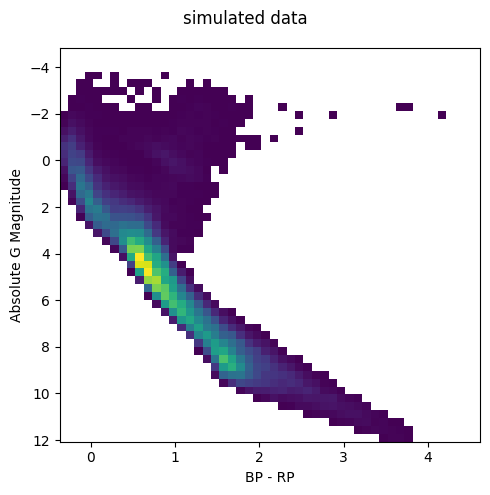

In [30]:
g_mag = x.numpy()[:,0]# - 5* np.log10(x.numpy()[:,3]) + 5
color_mag = x.numpy()[:,1] - x.numpy()[:,2]

#g_mag = x.numpy()[:,2] - 5* np.log10(1000/x.numpy()[:,0]) + 5
#color_mag = x.numpy()[:,1] - x.numpy()[:,3]

fig, ax = plt.subplots(figsize=(5,5))
fig.suptitle('simulated data')
ax.hist2d(color_mag, g_mag, bins=50, density=False, cmin=2)
ax.set_xlabel('BP - RP')
ax.set_ylabel('Absolute G Magnitude')
ax.invert_yaxis()
fig.tight_layout()

# Test for one star

g_mag, bp_mag, rp_mag, dist
tensor([  5.7337,  15.1420,  13.9611, 600.0000], dtype=torch.float64)


Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

torch.Size([2000, 5])


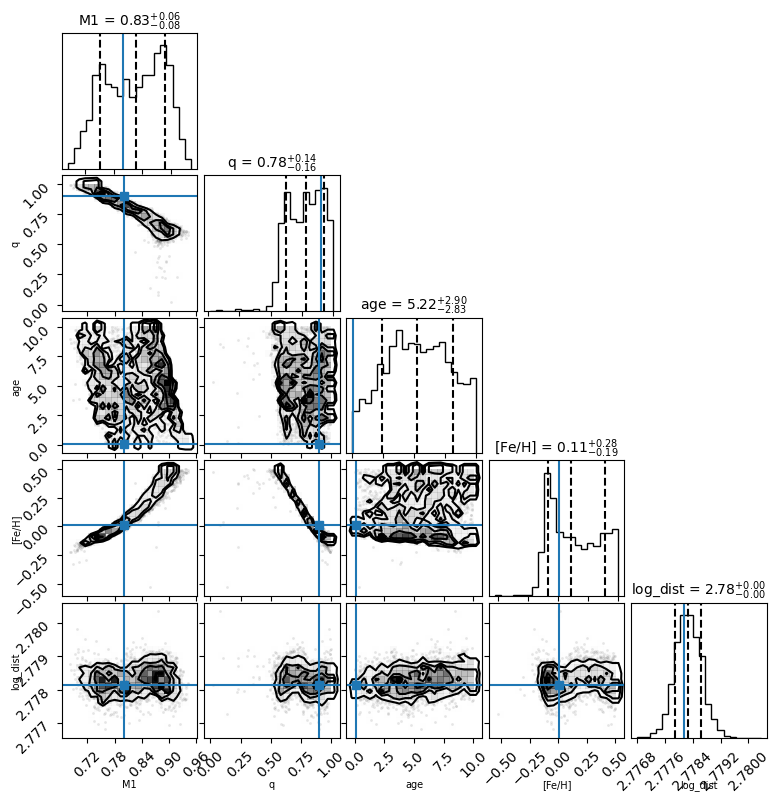

In [8]:
mass = 0.8
q = 0.9
age = 0.1
metallicity = 0.01
dist = 600 

truth = np.array([mass, q, age, metallicity, np.log10(dist)])
observation = simulator(truth)
print('g_mag, bp_mag, rp_mag, dist')
print(observation)
assert np.all(np.isfinite(np.array(observation)))

samples = posterior.sample((num_samples,), x=torch.tensor(observation), show_progress_bars=True) # sample_with='mcmc'
# num_samples

labels = ("M1", "q", "age", "[Fe/H]", "log_dist")
print(samples.shape)
n_dim = samples.numpy().shape[1]
fig, _ = plt.subplots(n_dim, n_dim, figsize=(8,8))
fig = corner.corner(samples.numpy(), labels=labels, truths=truth, quantiles=[0.16, 0.5, 0.84], show_titles=True, fig=fig,
                    title_kwargs={"fontsize":10}, label_kwargs=dict(fontsize=7), truth_color='C0')

In [ ]:
# fig = analysis.pairplot(
#     samples, 
#     points=truth,
#     labels=labels,
#     figsize=(10, 10),
#     points_colors=["tab:red"])

# Read data for a cluster

tensor([[  2.8389,   9.4262,   8.7873, 186.0027],
        [  3.6939,  10.3606,   9.5485, 185.0563],
        [  3.9296,  10.5895,   9.7409, 183.6977],
        [  4.1376,  10.7494,   9.8943, 179.3638],
        [  5.0278,  11.8319,  10.7596, 185.7776],
        [  5.9467,  12.8715,  11.5876, 187.0194],
        [  6.0186,  13.0088,  11.6211, 186.9411],
        [  7.1049,  14.1968,  12.6188, 186.3743],
        [  7.3619,  14.3675,  12.7251, 176.2112],
        [  7.3302,  14.5300,  12.8434, 190.2076]], dtype=torch.float64)


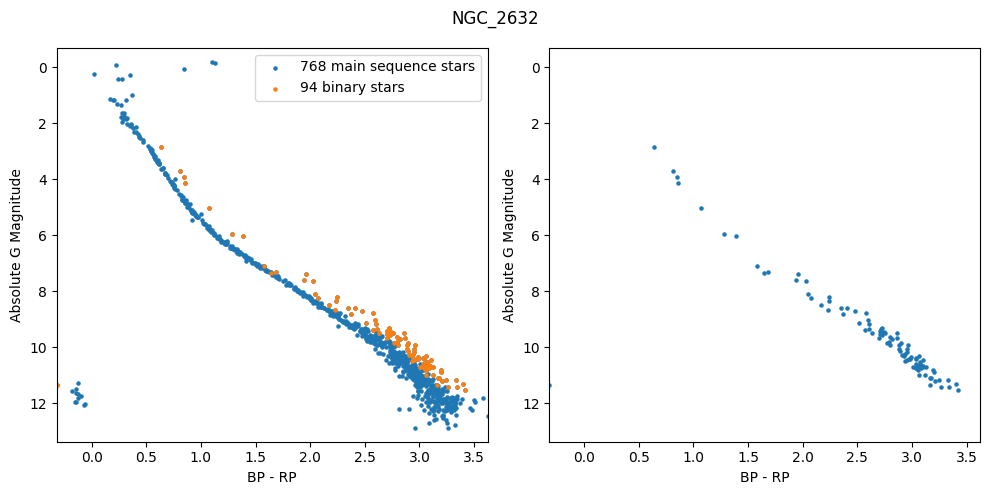

In [35]:
cluster = 'NGC_2632'#'NGC_2682'
df = pd.read_csv('../data_masses/{}.csv'.format(cluster))
#df = pd.read_csv('/home/steven/Dropbox/data_open_clusters/{}.csv'.format(cluster))
df['log_dist'] = np.log10(df['distance'])
df['g_mag'] = df['phot_g_mean_mag'] - 5*df['log_dist'] + 5
condition = (df['binary'] == True)

df_binary = df[condition]
observation_per_cluster = df_binary[['g_mag','phot_bp_mean_mag','phot_rp_mean_mag','distance']].to_numpy()
observation_per_cluster = torch.from_numpy(observation_per_cluster)
print(observation_per_cluster[:10,:])

d_edges = 0.5
custom_xlim = (df['bp_rp'].min(), df['bp_rp'].max())
custom_ylim = (df['g_mag'].min()-d_edges, df['g_mag'].max()+d_edges)

fig, ax = plt.subplots(1,2, figsize=(10,5))
fig.suptitle(cluster)
plt.setp(ax, xlim=custom_xlim, ylim=custom_ylim)

ax[0].scatter(df['bp_rp'], df['g_mag'], s=5, label='%s main sequence stars'%(len(df)-len(df[condition])))
#ax[0].scatter(df['bp_rp'][condition], df['g_mag'][condition], s=5, label='%s binary stars'%(len(df[condition])))
ax[0].scatter(observation_per_cluster[:,1].numpy() - observation_per_cluster[:,2].numpy(), observation_per_cluster[:,0].numpy(), \
              s=5, label='%s binary stars'%(len(df[condition])))
ax[0].set_xlabel('BP - RP')
ax[0].set_ylabel('Absolute G Magnitude')
ax[0].legend()
ax[0].invert_yaxis()

ax[1].scatter(df['bp_rp'][condition], df['g_mag'][condition], s=5)
ax[1].set_xlabel('BP - RP')
ax[1].set_ylabel('Absolute G Magnitude')
ax[1].invert_yaxis()

fig.tight_layout()

In [24]:
observation_per_cluster[:-7,:]#.shape

tensor([[  2.8389,   9.4262,   8.7873, 186.0027],
        [  3.6939,  10.3606,   9.5485, 185.0563],
        [  3.9296,  10.5895,   9.7409, 183.6977],
        [  4.1376,  10.7494,   9.8943, 179.3638],
        [  5.0278,  11.8319,  10.7596, 185.7776],
        [  5.9467,  12.8715,  11.5876, 187.0194],
        [  6.0186,  13.0088,  11.6211, 186.9411],
        [  7.1049,  14.1968,  12.6188, 186.3743],
        [  7.3619,  14.3675,  12.7251, 176.2112],
        [  7.3302,  14.5300,  12.8434, 190.2076],
        [  7.3712,  14.7082,  12.7491, 187.0150],
        [  7.6476,  15.0108,  12.9806, 185.5935],
        [  7.5921,  14.9906,  13.0489, 193.5494],
        [  8.1020,  15.4437,  13.3959, 182.2865],
        [  8.2114,  15.7336,  13.4915, 186.4999],
        [  8.2444,  15.6694,  13.5943, 188.2694],
        [  8.3555,  15.8241,  13.5854, 182.1640],
        [  8.5079,  15.9708,  13.7991, 186.0354],
        [  8.5907,  16.2007,  13.8512, 187.3591],
        [  8.6809,  16.1324,  13.9022, 181.3603],


# Do sampling for each one.

In [12]:
num_injections = len(observation_per_cluster)
num_injections, num_samples

(94, 2000)

In [15]:
#dir(posterior)

In [16]:
#posterior.sample.__doc__

In [28]:
observation_per_cluster[2,:]

tensor([  2.3346,  10.7600,  10.2512, 444.2360], dtype=torch.float64)

In [29]:
L = 5 # number of parameters
all_samples = np.empty((num_injections, num_samples, L))

for i in tqdm(range(len(observation_per_cluster))):
    obs = observation_per_cluster[i,:]
    all_samples[i] = posterior.sample((num_samples,), x=obs, show_progress_bars=False) # sample_with='mcmc'

 22%|██▏       | 26/117 [00:03<00:20,  4.41it/s]WARNING:root:Only 0.550% proposal samples are
                    accepted. It may take a long time to collect the remaining
                    1989 samples. Consider interrupting (Ctrl-C) and switching to
                    `build_posterior(..., sample_with='mcmc')`.
 25%|██▍       | 29/117 [00:07<00:57,  1.54it/s]WARNING:root:Only 0.700% proposal samples are
                    accepted. It may take a long time to collect the remaining
                    1986 samples. Consider interrupting (Ctrl-C) and switching to
                    `build_posterior(..., sample_with='mcmc')`.
 26%|██▌       | 30/117 [00:10<01:55,  1.32s/it]WARNING:root:Only 0.700% proposal samples are
                    accepted. It may take a long time to collect the remaining
                    1986 samples. Consider interrupting (Ctrl-C) and switching to
                    `build_posterior(..., sample_with='mcmc')`.
 26%|██▋       | 31/117 [00:13<02:29,  1.74

In [ ]:
# #_, L = sbi_prior.sample((1, )).shape
# L = 5 # number of parameters

# all_samples = np.empty((num_injections, num_samples, L))

# for i, obs in enumerate(tqdm(observation_per_cluster)):
#     all_samples[i] = posterior.sample((num_samples,), x=obs, show_progress_bars=False) # sample_with='mcmc'

In [ ]:
# Let's see where the truth was as a percentile in each injection.

In [30]:
all_samples.shape, len(all_samples)

((117, 2000, 5), 117)

In [31]:
#100*3000 - 160000 # empanadas
all_samples[0]

array([[ 1.71687019,  0.20461966,  1.22802162, -0.52657241,  2.64184141],
       [ 1.86904979,  0.12335108,  0.89641601, -0.64948767,  2.64153886],
       [ 1.59936488,  0.46477675,  1.30501401, -1.10429144,  2.64164591],
       ...,
       [ 1.56489849,  0.89983886,  1.27440882, -0.97147095,  2.64160442],
       [ 2.32391453,  0.33412316,  0.44948256,  0.23930401,  2.64194512],
       [ 2.28023648,  0.38174421,  0.47567874,  0.22642089,  2.64161205]])

# Get params from sampling per star

In [53]:
estimated_params = np.zeros((len(all_samples), 5)) 
#errors_up = np.zeros_like(estimated_params) 
#errors_down = np.zeros((len(all_samples), 4)) 

for i in range(len(all_samples)):
    params = np.percentile(all_samples[i], 50, axis=0)
    for j in range(len(params)):
        estimated_params[i,j] = params[j]

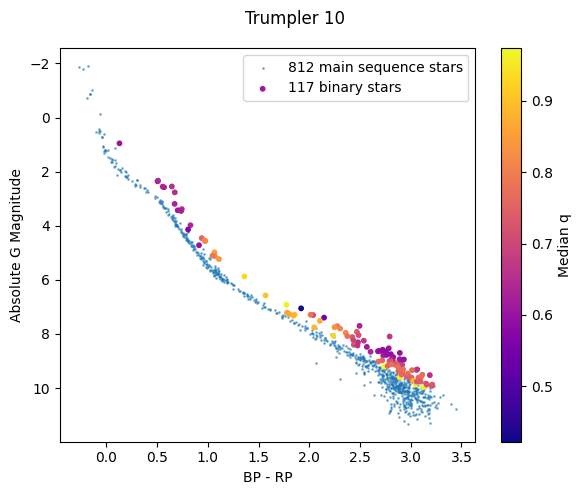

In [54]:
fig, ax = plt.subplots(figsize=(6,5))
fig.suptitle(cluster. replace('_',' '))
ax.scatter(df['bp_rp'], df['g_mag'], s=1, c='C0', alpha=0.5, label='%s main sequence stars'%(len(df)-len(df[condition])))
sc = ax.scatter(df['bp_rp'][condition], df['g_mag'][condition], s=10, label='%s binary stars'%(len(df[condition])), c=estimated_params[:,1],\
                cmap='plasma')
ax.set_xlabel('BP - RP')
ax.set_ylabel('Absolute G Magnitude')
ax.invert_yaxis()
ax.legend()
fig.colorbar(sc, label='Median q', location='right', ax=ax)
fig.tight_layout()
fig.savefig('./images/binary_test.png', bbox_inches='tight')

In [65]:
estimated_params

array([[ 1.96594959e+00,  6.06719524e-01,  7.49792039e-01,
        -2.64571697e-01,  2.64166582e+00],
       [ 1.38461351e+00,  6.15859956e-01,  2.12876236e+00,
        -2.02687651e-01,  2.62659824e+00],
       [ 1.39850068e+00,  6.38682812e-01,  2.11362314e+00,
        -1.74149796e-01,  2.64793015e+00],
       [ 1.34532237e+00,  6.50905758e-01,  3.08234727e+00,
        -6.73831347e-03,  2.62092102e+00],
       [ 1.33846194e+00,  6.45657718e-01,  2.44573975e+00,
        -1.34777054e-01,  2.63187206e+00],
       [ 1.33711576e+00,  6.24984413e-01,  2.61611283e+00,
        -1.17866553e-01,  2.63852453e+00],
       [ 1.30397105e+00,  6.51654303e-01,  3.50954139e+00,
         2.93800021e-02,  2.61598551e+00],
       [ 1.19018745e+00,  6.33120090e-01,  3.94148743e+00,
        -1.37960995e-02,  2.63583601e+00],
       [ 1.17384553e+00,  6.51273251e-01,  4.83569884e+00,
         1.16820421e-01,  2.63911724e+00],
       [ 1.14623135e+00,  6.09878033e-01,  4.53937531e+00,
         2.24275747e-03

In [66]:
df_binary

,Unnamed: 0,source_id,ra,ra_error,dec,dec_error,l,b,parallax,parallax_error,...,distance,x,y,z,g_mag,mass_predicted,binary,log_dist,M1,q_ratio
16,16,5524172955997468672,131.982411,0.014929,-42.589472,0.016745,262.902515,0.590560,2.288712,0.018811,...,439.263751,-54.271586,-435.874684,4.527505,0.953672,0.398852,True,2.642725,0.986230,0.599276
50,50,5330276863582453632,135.705815,0.010570,-46.206029,0.011268,267.380575,0.282447,2.376348,0.013569,...,422.971461,-19.330223,-422.524380,2.085078,2.357265,0.237526,True,2.626311,0.587567,0.590443
54,54,5524153542751548800,132.421855,0.012390,-42.443742,0.013544,262.993803,0.933809,2.268921,0.015726,...,444.236000,-54.179192,-440.860322,7.239855,2.334613,0.227848,True,2.647614,0.613076,0.601119
55,55,5523934911734512384,132.585425,0.013013,-42.974942,0.014140,263.480942,0.690166,2.408563,0.016728,...,417.513000,-47.398307,-414.783334,5.029098,2.548037,0.218834,True,2.620670,0.589817,0.594142
59,59,5523369243062322176,129.809169,0.008261,-43.035190,0.009541,262.266105,-0.937554,2.348214,0.010609,...,428.155085,-57.610098,-424.203692,-7.005770,2.554124,0.211925,True,2.631601,0.562983,0.617008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
613,613,5529511875230699392,128.206129,0.077031,-38.834348,0.092764,258.181794,0.621624,2.291340,0.104206,...,436.425879,-89.377801,-427.149549,4.734857,9.747679,-0.273360,True,2.639910,0.000000,0.000000
620,620,5525383483944324992,132.227254,0.063275,-41.255249,0.069685,261.980804,1.572450,2.434311,0.081521,...,417.207522,-58.180514,-412.972244,11.448580,9.872139,-0.274580,True,2.620352,0.000000,0.000000
641,641,5523937175177409408,132.663365,0.082287,-42.863544,0.091023,263.431103,0.804986,2.444204,0.106002,...,409.131234,-46.799082,-406.405184,5.747960,9.967445,-0.277009,True,2.611863,0.000000,0.000000
646,646,5524185188069302272,131.787996,0.076497,-42.513600,0.096093,262.753524,0.526745,2.361597,0.099826,...,429.921417,-54.227067,-426.469493,3.952397,9.874723,-0.277697,True,2.633389,0.000000,0.000000


In [69]:
df_binary['M1'] = 0
df_binary['q_ratio'] = 0
df_binary.reset_index(inplace=True)

for i in range(len(df_binary)):
    df_binary['M1'][i] = estimated_params[i,0]
    df_binary['q_ratio'][i] = estimated_params[i,1]

In [76]:
df_binary.to_csv('../data_masses/binaries/{}.csv'.format(cluster))

In [74]:
print(df_binary['q_ratio'].min(), df_binary['q_ratio'].max())
print(df_binary['M1'].min(), df_binary['M1'].max())

0.4224949926137924 0.9737186133861542
0.39103399217128754 1.9659495949745178


In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
fig.suptitle(cluster)

for i in range(len(estimated_params[:,1])):
    if estimated_params[:,1][i] > 0.5:
        color_ = df['phot_bp_mean_mag'][i] - df['phot_rp_mean_mag'][i]
        ax.scatter(color_, df['phot_g_mean_mag'][i], cmap='viridis', c=estimated_params[:,1][i], s=5)

#sc = ax.scatter(df['phot_bp_mean_mag'] - df['phot_rp_mean_mag'], df['phot_g_mean_mag'], cmap='viridis', c=estimated_params[:,1], s=5)
ax.set_xlabel('BP - RP')
ax.set_ylabel('G')
ax.invert_yaxis()
#fig.colorbar(sc, label='Median q', location='right', ax=ax) 
fig.tight_layout()

In [ ]:
from scipy.stats import percentileofscore as pos
true_theta = np.array(true_theta)

percentiles = np.empty((num_injections, L))
for i, this_theta in enumerate(tqdm(np.array(true_theta))):
    for j, t in enumerate(this_theta):
        percentiles[i, j] = pos(all_samples[i, :, j], t)

In [ ]:
fig, axes = plt.subplots(2, 2)
for i, ax in enumerate(axes.flat):
    ax.hist(percentiles[:, i])
    ax.set_xlabel(labels[i])

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    lower, mean, upper = np.percentile(all_samples[:, :, i], [16, 50, 84], axis=1)
    yerr_pos = upper - mean
    yerr_neg = mean - lower
    ax.errorbar(
        true_theta[:, i],
        mean,
        yerr=(yerr_neg, yerr_pos),
        fmt='o'
    )
    limits = np.array([ax.get_xlim(), ax.get_ylim()])
    limits = (np.min(limits), np.max(limits))
    ax.plot(limits, limits, c="#666666", ls=":", zorder=-1)
    ax.set_xlim(limits)
    ax.set_ylim(limits)
    ax.set_title(labels[i])
    ax.set_xlabel(f"injected")
    ax.set_ylabel(f"recovered")

In [ ]:
## TODO: Check that this is the right thing to be doing here!
fig, ax = plt.subplots(figsize=(6, 6))

for i, label in enumerate(labels):
    x = percentiles.T[i]
    y = true_theta.T[i]
    ax.plot(
        np.cumsum(x)/np.sum(x),
        np.cumsum(y)/np.sum(y),
        label=label
    )
limits = [0, 1]
ax.plot(limits, limits, c="#666666", zorder=-1, ls=":")
ax.legend()
ax.set_xlim(limits)
ax.set_ylim(limits)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic_2d

from matplotlib.colors import LogNorm 
def plot_binned_statistic(x, y, z, bins=100, function=np.nanmedian,
                          xlabel=None, ylabel=None, zlabel=None,
                          ax=None, colorbar=False, figsize=(8, 8),
                          vmin=None, vmax=None, min_entries_per_bin=None,
                          subsample=None, mask=None, full_output=False, **kwargs):
    
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)
    else:
        fig = ax.figure
    
    finite = np.isfinite(x * y * z)
    if mask is not None:
        finite *= mask
    if subsample is not None:
        idx = np.where(finite)[0]
        if subsample < 1:
            subsample *= idx.size
        if int(subsample) > idx.size:
            finite = idx
        else:
            finite = np.random.choice(idx, int(subsample), replace=False)
    
    H, xedges, yedges, binnumber = binned_statistic_2d(
        x[finite], y[finite], z[finite],
        statistic=function, bins=bins)

    if min_entries_per_bin is not None:
        if function != "count":
            H_count, xedges, yedges, binnumber = binned_statistic_2d(
                x[finite], y[finite], z[finite],
                statistic="count", bins=bins)

        else:
            H_count = H

        H[H_count < min_entries_per_bin] = np.nan


    if (vmin is None or vmax is None) and "norm" not in kwargs:
        vmin_default, med, vmax_default = np.nanpercentile(H, kwargs.pop("norm_percentiles", [5, 50, 95]))
        if vmin is None:
            vmin = vmin_default
        if vmax is None:
            vmax = vmax_default
    
    imshow_kwds = dict(
        vmin=vmin, vmax=vmax,
        aspect=np.ptp(xedges)/np.ptp(yedges), 
        extent=(xedges[0], xedges[-1], yedges[-1], yedges[0]),
        cmap="inferno",
        interpolation="bilinear")
    imshow_kwds.update(kwargs)
    
    image = ax.imshow(H.T, **imshow_kwds)
    if colorbar:
        cbar = plt.colorbar(image, ax=ax)
        if zlabel is not None:
            cbar.set_label(zlabel)

    if xlabel is not None:
        ax.set_xlabel(xlabel)
    if ylabel is not None:
        ax.set_ylabel(ylabel)

    #fig.tight_layout()

    return (fig, image) if full_output else fig

In [ ]:
c

In [ ]:
# Plot the training set and the injection set in data coords
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
# b, r, g
c_index = 1 # q
c = x.T[c_index]
#vmin, vmax = (min(c), max(c))
plot_binned_statistic(
    np.array(x.T[0] - x.T[1]),
    np.array(x.T[2]),
    np.array(x.T[2]),
    norm=LogNorm(),
    function="count",
    min_entries_per_bin=1,
    interpolation="nearest",
    bins=200,
    ax=axes[0]
)

axes[1].scatter(
    true_obs.T[0] - true_obs.T[1],
    true_obs.T[2],
)
for ax in axes:
    ax.set_xlabel("BP-RP")
    ax.set_ylabel("M_G")
axes[1].set_xlim(axes[0].get_xlim())
axes[1].set_ylim(axes[0].get_ylim())

axes[0].set_title("Training set")
axes[1].set_title("Injection set")

In [ ]:
delta_q = np.abs(true_theta[:, 1] - np.mean(all_samples[:, :, 1], axis=1))
bad_index = np.argmax(delta_q)
bad_theta = true_theta[bad_index]
print(bad_theta)

In [ ]:
print(all_samples.shape)
fig = analysis.pairplot(
    all_samples[bad_index], 
    points=bad_theta,
    labels=labels,
    figsize=(10, 10),
    points_colors=["tab:red"]
)

In [ ]:
delta_q = np.abs(true_theta[:, 1] - np.mean(all_samples[:, :, 1], axis=1))
good_index = np.argmin(delta_q)
good_theta = true_theta[good_index]
print(good_theta)

In [ ]:
fig = analysis.pairplot(
    all_samples[good_index], 
    points=good_theta,
    labels=labels,
    figsize=(10, 10),
    points_colors=["tab:red"]
)